In [1]:
import numpy as np

In [2]:
%matplotlib widget
import matplotlib.pyplot as plt

In [423]:
#длина и глубина моделируемого участка, м
l, h = 10E-3, 1E-3
#мин и макс скорости печати, м/с
v_min, v_max = 10E-3, 100E-3
#шаг по времени, с
#dt = 0.000072 Позже выбирается из соображений устойчивости
#диаметр сопла, м
ex_d = 0.4E-3
#температура среды (воздуха), град Цел
t_air = 60
#толщина наносимого слоя, м
hh = 0.2E-3
#температура сопла, град Цел
ex_t = 300

#########################################

#мин шаг сетки координат
#dX = v_max*dt Теперь выбирается вручную
dx = 0.01*1E-3
#количество участков сетки
x_l, x_h = int(l/dx), int(h/dx)
#диаметр сопла в шагах
ex_d_x = int(ex_d/dx)
#толщина наносимого слоя в шагах
hh_x = int(hh/dx)
#температура подложки (ниже лежащих слоёв), град Цел
t_base = t_air

#теплопроводность Вт/(м*грЦ), теплоемкость Дж/(кг*грЦ), плотность кг/м^3
hi, cp, ro = 0.3, 1250, 1350
#коэффициент температуропроводности a^2 (a2)
a2_petg = hi/(cp*ro)
#теплопроводность воздуха Вт/(м*грЦ) от температуры, шаг 10 гр
hi_air = [0.0244,
          0.0251, 0.0259, 0.0267, 0.0276, 0.0283,
          0.0290, 0.0296, 0.0305, 0.0313, 0.0321,
          0.0328, 0.0334, 0.0342, 0.0349, 0.0357,
          0.0364, 0.0371, 0.0378, 0.0386, 0.0427,
          0.0460, 0.0491, 0.0521]
#теплоемкость воздуха Дж/(кг*грЦ) от температуры, шаг 10 гр, давление 10^5 Па
cp_air = [1005,
          1005, 1005, 1005, 1005, 1005,
          1005, 1009, 1009, 1009, 1009,
          1009, 1009, 1011, 1013, 1015,
          1017, 1020, 1022, 1024, 1026,
          1028, 1030, 1032]
#плотность воздуха кг/(м^3) от температуры, давление 10^5 Па, ro=p*M/(R*T)
def ro_air(temp):
    return 10**5*29/(8.31447*(273.15+temp))
#коэффициент температуропроводности воздуха a^2 (a2)
a2_air = hi_air[int(t_air/10)]/(cp_air[int(t_air/10)]*ro_air(t_air))

#########################################################

#шаг по времени, с
#dt = 0.000072 Позже выбирается из соображений устойчивости
dt=0.25*dx**2/a2_petg
#дискретность шага по времени
dt/=1

dt, x_l, x_h

(0.00014062500000000004, 999, 100)

In [424]:
#нанесение горячего слоя
def addLayer(ex_shift):
    T[ex_shift:ex_shift+ex_d_x,:hh_x] = ex_t
    a2[ex_shift:ex_shift+ex_d_x,:hh_x] = a2_petg
    return

In [425]:
#приращение температуры
def getIncT(Lap):
    return a2*Lap*dt

In [426]:
#кадр цикла расчета
'''def step(T, shift):
    top_layer = np.roll(ex_T, shift)
    addLayer(T, shift)
    dTdx = getDerX1(T, top_layer)
    ddTdxx = getDerX2(dTdx)
    dT = getIncT(ddTdxx)
    #print(T.shape, dTdx.shape, ddTdxx.shape)
    return T+dT'''

def heatStep(heatmap, ex_shift):
    top_layer = np.roll(ex_T, ex_shift)
    addLayer(ex_shift)
    sub_matrices = np.lib.stride_tricks.as_strided(np.pad(heatmap, 1, 'constant', constant_values=t_air),view_shape,strides)
    #print(sub_matrices[0,0,:,:])
    Lap=np.einsum('ij,klij->kl',conv_filter,sub_matrices, optimize=True)/dx**2
    dT=getIncT(Lap)
    return dT

In [427]:
from IPython.display import display, clear_output

In [428]:
#температурная сетка
T = np.full((x_l, x_h), t_base, dtype='float64')
#сетка температуропроводности
a2 = np.r_['1,2,1', np.full((x_l, hh_x), a2_air),np.full((x_l, x_h-hh_x), a2_petg)]
#слой сопла
ex_T = np.r_[np.full(ex_d_x,ex_t),np.full((x_l-ex_d_x), t_base)][:,np.newaxis]

In [429]:
T = np.full((x_l, x_h), t_base, dtype='float64')

#скорость печатающей головки, мм/с
v_ex = 60

shift_coef = v_ex*1E-3*dt/dx

#температура плавления
t_m = 240
#сетка подплавлений
T_m = np.full((x_l, x_h), False, dtype='float16')

#время эксперимента, c
Tm_stop = 0.15
#время эксперимента в шагах
tm_stop = int(Tm_stop/dt)

'''for t in range(tm_stop):
    shift = int(t*shift_coef/10)
    T = step(T, shift)
    T_m[:,hh_x:][T[:,hh_x:]>t_m] = True'''

conv_filter = np.array([[0,1,0],[1,-4,1],[0,1,0]])
sub_shape = conv_filter.shape
T_pdd = np.pad(T, 1, 'constant', constant_values=t_air)
view_shape = tuple(np.subtract(T_pdd.shape, sub_shape) + 1) + sub_shape
strides = T_pdd.strides + T_pdd.strides

for t in range(tm_stop):
    ex_shift = int(t*shift_coef)
    T += heatStep(T, ex_shift)
    T_m[:,hh_x:][T[:,hh_x:]>t_m] += dt
    clear_output(wait=True)
    display('Iteration '+repr(t)+' out of '+repr(tm_stop-1)+'. Total: %d%%'%(100*t/(tm_stop-1)))

'Iteration 1065 out of 1065. Total: 100%'

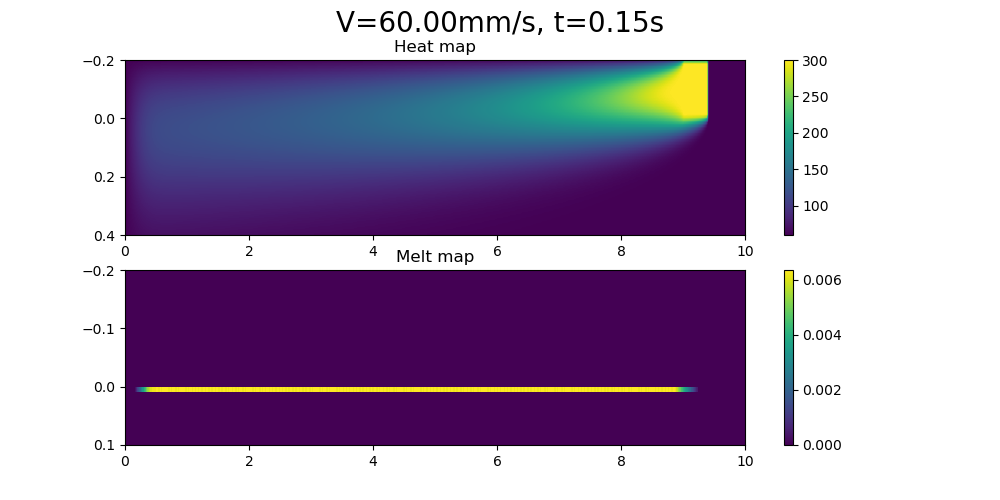

In [453]:
#глубина просмотра, мм
H_view = 0.4
#глубина просмотра в шагах
h_view = int(1E-3*H_view/dx)
#глубина просмотра проплава в шагах
h_view2 = int(h_view/4)

plt.close('all')
fig = plt.figure(figsize=(10, 5))
fig.suptitle("V=%.2fmm/s, t=%.2fs"%((dx/dt*shift_coef*1E3),Tm_stop), fontsize=20)
plt.subplot(211)
plt.title("Heat map")
im = plt.imshow(T[:,:h_view+hh_x].T, extent=[0,l*1E3,h_view*dx*1E3,-hh_x*dx*1E3], aspect='auto')#, interpolation='gaussian')
plt.colorbar(location='right', anchor=(0, 0.5), shrink=1.0)
plt.subplot(212)
plt.title("Melt map")
im = plt.imshow(T_m[:,:h_view2+hh_x].T, extent=[0,l*1E3,h_view2*dx*1E3,-hh_x*dx*1E3], aspect='auto', interpolation='none')
plt.colorbar(location='right', anchor=(0, 0.5), shrink=1.0)
plt.show()

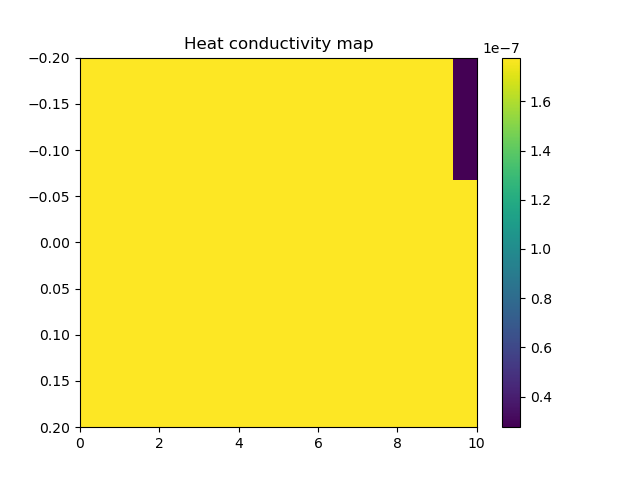

In [452]:
plt.close('all')
plt.title("Heat conductivity map")
im = plt.imshow(a2[:,:h_view+hh_x].T, extent=[0,l*1E3,(h_view-hh_x)*dx*1E3,-hh_x*dx*1E3], aspect='auto', interpolation='none')
plt.colorbar(location='right', anchor=(0, 0.5), shrink=1.0)
plt.show()